In [12]:
# libraries
import pandas as pd
import numpy as np
import nltk
# from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag import pos_tag
import string
import spacy
import en_core_web_sm
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
nlp = en_core_web_sm.load()

# python3 -m spacy download en

# download stopwords and wordnet and punctuations

# nltk.download("stopwords")
# nltk.download("wordnet")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/himani/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /Users/himani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [26]:
## read raw file

raw_file = pd.read_csv("LabelledData (1).txt", sep = ",,,", header = None)
raw_file.columns = ['questions','labels']
raw_file.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


,questions,labels
0,how did serfdom develop in and then leave russ...,unknown
1,what films featured the character popeye doyle ?,what
2,how can i find a list of celebrities ' real na...,unknown
3,what fowl grabs the spotlight after the chines...,what
4,what is the full form of .com ?,what


Text(0,0.5,'Frequency')

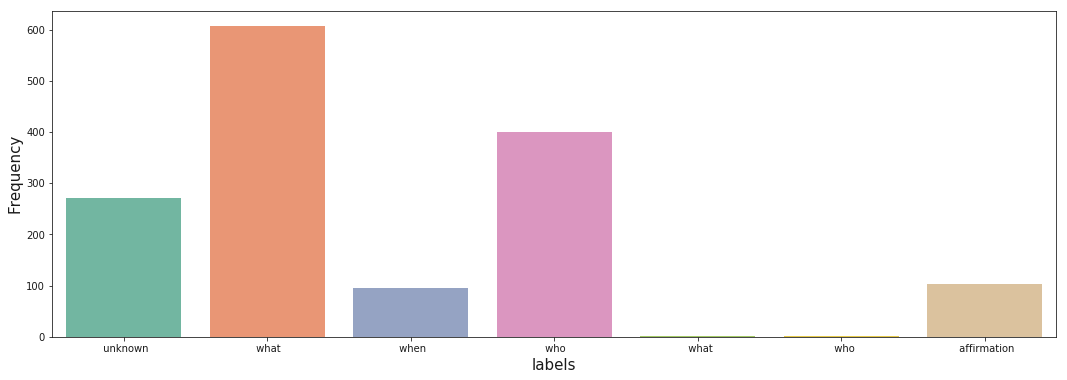

In [25]:
### distribution of levels in labels in training set

sns.set_color_codes()

fig, ax1 = plt.subplots(1,1, figsize = (18,6))

sns.countplot('labels', data = raw_file,palette="Set2", ax = ax1)
ax1.set_xlabel("labels", size = 15)
ax1.set_ylabel("Frequency", size = 15)

In [34]:
## clean questions

lemma = WordNetLemmatizer()
def clean_tokenize(document):
    document = re.sub('[^\w_\s-]', ' ',document)       #remove punctuation marks and other symbols
    tokens = nltk.word_tokenize(document)              #Tokenize sentences
    cleaned_article = " ".join(lemma.lemmatize(item) for item in tokens)
    return cleaned_article

raw_file['clean_ques'] = raw_file['questions'].apply(clean_tokenize)
raw_file.head()

,questions,labels,clean_ques
0,how did serfdom develop in and then leave russ...,unknown,how did serfdom develop in and then leave russia
1,what films featured the character popeye doyle ?,what,what film featured the character popeye doyle
2,how can i find a list of celebrities ' real na...,unknown,how can i find a list of celebrity real name
3,what fowl grabs the spotlight after the chines...,what,what fowl grab the spotlight after the chinese...
4,what is the full form of .com ?,what,what is the full form of com


### Create features from questions
- WH-word
- WH word POS
- pos of word next to WH word
- Root POS: The part of speech of the word at the root of the dependency parse tree.

In [37]:
raw_file['clean_ques'][0]

'how did serfdom develop in and then leave russia'

In [41]:
nlp = en_core_web_sm.load()

In [59]:
x = nlp(raw_file['clean_ques'][1])

In [60]:
list(x.sents)

[what film featured the character popeye doyle]

In [61]:
tags = {w.pos: w.pos_ for w in x}
tags

{83: 'ADJ', 89: 'DET', 91: 'NOUN', 99: 'VERB'}

In [62]:
for word in list(x.sents)[0]:
    print(word, word.pos_)

what ADJ
film NOUN
featured VERB
the DET
character NOUN
popeye NOUN
doyle NOUN


In [72]:
def pos_question(row):
    
    # get linguistic annotations of question
    en_row = nlp(u''+ row)  
    sent_list = list(en_row.sents)
    wh_bi_gram = []
    root_token = ""
    wh_pos = ""
    wh_nbor_pos = ""
    wh_word = ""

    for token in sent_list[0]:
        if token.tag_ == "WDT" or token.tag_ == "WP" or token.tag_ == "WP$" or token.tag_ == "WRB":
            wh_pos = token.tag_
            wh_word = token.text
            wh_bi_gram.append(token.text)
            wh_bi_gram.append(str(en_row[token.i]))
            wh_nbor_pos = en_row[token.i].tag_
        if token.dep_ == "ROOT":
            root_token = token.tag_
    return [wh_pos, wh_word, wh_bi_gram, wh_nbor_pos, root_token]

In [73]:
raw_file['pos'] = raw_file['clean_ques'].apply(pos_question)

In [74]:
raw_file.head(10)

,questions,labels,clean_ques,pos
0,how did serfdom develop in and then leave russ...,unknown,how did serfdom develop in and then leave russia,"[WRB, how, [how, how], WRB, VB]"
1,what films featured the character popeye doyle ?,what,what film featured the character popeye doyle,"[WDT, what, [what, what], WDT, VBD]"
2,how can i find a list of celebrities ' real na...,unknown,how can i find a list of celebrity real name,"[WRB, how, [how, how], WRB, VB]"
3,what fowl grabs the spotlight after the chines...,what,what fowl grab the spotlight after the chinese...,"[WDT, what, [what, what], WDT, VBP]"
4,what is the full form of .com ?,what,what is the full form of com,"[WP, what, [what, what], WP, VBZ]"
5,what contemptible scoundrel stole the cork fro...,what,what contemptible scoundrel stole the cork fro...,"[WP, what, [what, what], WP, VBD]"
6,what team did baseball 's st. louis browns bec...,what,what team did baseball s st louis brown become,"[WDT, what, [what, what], WDT, VBD]"
7,what is the oldest profession ?,what,what is the oldest profession,"[WP, what, [what, what], WP, VBZ]"
8,what are liver enzymes ?,what,what are liver enzyme,"[WP, what, [what, what], WP, VBP]"
9,name the scar-faced bounty hunter of the old w...,unknown,name the scar-faced bounty hunter of the old west,"[, , [], , VB]"
